In [1]:
import json,re,boto3
import numpy as np
import pandas as pd
from datetime import *
from dateutil import parser, tz

import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# get rid of gridlines 
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

import imp
sentiment = imp.load_source('sentiment', '/Users/andrew/git-local/sentiment.py')

In [2]:
client = boto3.client('sdb')
domain_name = "sentiment"

In [4]:
client.create_domain(DomainName=domain_name)

{'ResponseMetadata': {'BoxUsage': '0.0055590278',
  'HTTPStatusCode': 200,
  'RequestId': '183d074a-4220-4143-bbb1-49610f84d331'}}

In [5]:
def update_tz(d):
    ''' Updates time zone for date stamp to US EST (the time zone of the debates) '''
    def convert_timezone(item):
        from_zone = tz.gettz('UTC')
        to_zone = tz.gettz('America/New_York')
        utc = d.replace(tzinfo=from_zone)
        return utc.astimezone(to_zone)
    
    return convert_timezone(d)

In [6]:
labMT, mtList, wordList = sentiment.emotionFileReader(1.0, returnVector=True)

In [8]:
details = [{"party":"gop","ddate":"sep16"}, {"party":"dem","ddate":"oct13"}]

for event in details:
    
    party = event['party']
    ddate  = event['ddate']
    path = party+"/"+ddate+"/"
    
    raw = []
    for hr in ['19','20','21','22','23']:
        with open(path+hr+'.txt','r') as f:

            raw.extend(f.readlines())

    # read in as array of dicts
    rows = np.array([json.loads(line) for line in raw])
    # we only need some of these keys, and the others may cause trouble for pandas
    keys = np.array(['first_term','text','timestamp','tweet_id','username'])
    for row in rows:
        for k in row.keys():
            if k not in keys:
                del row[k]

    df = pd.DataFrame.from_records(rows)
    
    interval = 30
    df['timestamp'] = pd.to_datetime(df.timestamp)
    df['timestamp'] = df.timestamp.apply(
                        lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour, 
                                            dt.minute,interval*(dt.second // interval))
                      )
    df.timestamp = df.timestamp.apply(update_tz)

    g = df.groupby(['first_term',pd.TimeGrouper(str(interval)+'S',key="timestamp")])

    candidate_dict = {}
    candidate_names = df.first_term.unique()
    tweet_counts = g.text.count()

    for candidate in candidate_names:
        try:
            n = tweet_counts[candidate]
        except:
            n = 0
        candidate_dict[candidate] = { 'party':party if candidate is not 'general' else 'general',
                                      'num_tweets':n,
                                      'sentiment_avg':'',
                                      'sentiment_std':'',
                                      'highest_sentiment_tweet':'',
                                      'lowest_sentiment_tweet':''
                                     }
        
    cts = g.text.count().reset_index().sort_values(by=['timestamp','first_term'])
    cts.columns = ['first_term','timestamp','count']
    sentidf = g.text.apply(lambda x: sentiment.emotion(' '.join(x),labMT, return_scores=True))
    sentidf = sentidf.reset_index()

    sentidf['prop_words_scored'] = 0
    sentidf['total_word_ct'] = 0
    sentidf['sentiment_avg'] = 0
    sentidf['sentiment_std'] = 0

    sentidf.sentiment_avg = [x[0] for x in sentidf.text]
    sentidf.sentiment_std = [x[1] for x in sentidf.text]
    sentidf.total_word_ct = [x[5] for x in sentidf.text]
    sentidf.prop_words_scored = [x[6] for x in sentidf.text]
    sentidf.drop('text',1,inplace=True)
    
    

    finaldf = pd.concat([sentidf.sort_values(by=['timestamp','first_term']),cts.ix[:,'count']],1).reset_index(drop=True)

    for cname, grouped in finaldf.groupby('first_term'):
        # gives datetime in epoch seconds (that's how we do it in utils.py)
        #item_name = ts.strftime('%s')
        
        for i, (ts, grouped2) in enumerate(grouped.groupby('timestamp')):
            record = []
            ts_str = ts.strftime('%s')
            item_name = '_'.join([cname,ts_str])
            sentiment_data = grouped.ix[grouped.first_term==cname,['count','total_word_ct','prop_words_scored','sentiment_avg','sentiment_std']].to_dict(orient="records")
            record.append({"Name":"data", "Value": json.dumps(sentiment_data[i]), "Replace":False})
            record.append({"Name":"timestamp", "Value": ts_str, "Replace":False})
            record.append({"Name":"candidate", "Value": cname, "Replace":False})
            client.put_attributes(
                DomainName = domain_name,
                ItemName   = item_name,
                Attributes = record 
            )        

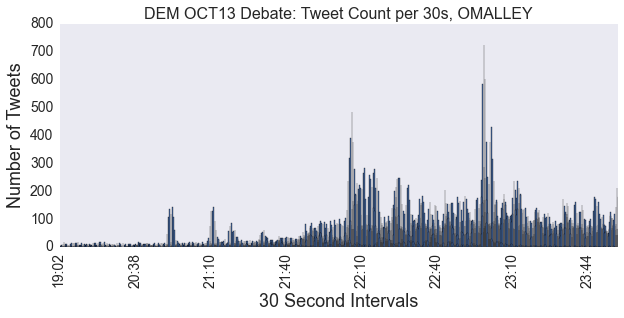

In [44]:

for name in candidate_names:
    n= 60
    ax = candidate_dict[name]['num_tweets'].plot(kind='bar',figsize=(10,4))
    ticks = ax.xaxis.get_ticklocs()
    xticklabels = [l.get_text().split(" ")[1].split('-')[0][:-3] for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::n])
    ax.xaxis.set_ticklabels(xticklabels[::n], fontsize=14)
    ax.set_ylabel("Number of Tweets",fontsize=18)
    ax.set_xlabel("30 Second Intervals",fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title("{party} {d} Debate: Tweet Count per 30s, {who}".format(party=party.upper(),d=ddate.upper(),who=name.upper()),fontsize=16)
    plt.savefig("_".join([party,ddate,name]),bbox_inches='tight')
    #ax.figure.show()

Note: If making histograms, limit df to time of debate. Eg. dem oct 13 debate is 830-11pm

In [10]:
start_time = datetime.strptime("20:30:00","%H:%M:%S").time()
end_time = datetime.strptime("23:00:00","%H:%M:%S").time()
actualdf = df.ix[(df.timestamp.dt.time >= start_time) & (df.timestamp.dt.time <= end_time),:]
gactual = df.groupby(['first_term',pd.TimeGrouper(str(interval)+'S',key="timestamp")])
ctdf = pd.DataFrame(gactual.text.count()).reset_index()

In [25]:
for cname in candidate_names:
    mtavg, mtstd, mtvec, used, unused = sentiment.emotion(each_cand_tweets[cname],labMT, return_scores=True)
    print 'use proprotion for {}: {}'.format(cname, len(set(used))/float(len(set(each_cand_tweets[cname].split(" ")))))
    
    print np.where(np.array(mtvec)==max(mtvec))[0]
    max_ix = np.random.choice(np.where(np.array(mtvec)==max(mtvec))[0])
    print 'highest scoring tweet: {}'.format(used[max_ix])
    min_ix = np.random.choice(np.where(np.array(mtvec)==min(mtvec))[0])
    print 'lowest scoring tweet: {}'.format(used[min_ix])

use proprotion for general: 0.0433460076046
[936]
highest scoring tweet: laughter
lowest scoring tweet: american
use proprotion for sanders: 0.0514128728414
[ 81 100 186 235 296 299 303 313]
highest scoring tweet: love
lowest scoring tweet: american
use proprotion for clinton: 0.0519673348181
[ 10 104 105 190 201]
highest scoring tweet: love
lowest scoring tweet: american
use proprotion for omalley: 0.0545454545455
[10]
highest scoring tweet: entertaining
lowest scoring tweet: horse


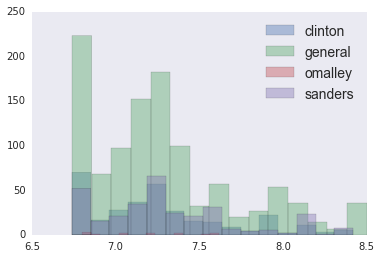

In [53]:
plt.figure(figsize=(6,4))
for c in each_cand_sent:
    plt.hist(c[2],bins=15,alpha=0.4)
plt.legend(each_cand_sent.index.values.astype(str),fontsize=14)